In [ ]:
import os
import numpy as np
import pandas as pd
import zipfile
import timeit


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import metrics
from tensorflow.keras.models import Sequential

In [ ]:
# Unzip all the zipped csv files using zipfile

with zipfile.ZipFile("/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip", "r") as f:
    f.extractall("/kaggle/working/")
    
with zipfile.ZipFile("/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip", "r") as f:
    f.extractall("/kaggle/working/")
    
with zipfile.ZipFile("/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip", "r") as f:
    f.extractall("/kaggle/working/")

In [ ]:
# Get the data

full_data_path = "/kaggle/working/train.csv"
test_data_X_path = "/kaggle/working/test.csv"
test_data_y_path = "/kaggle/working/test_labels.csv"

full_data = pd.read_csv(full_data_path)
test_data_X = pd.read_csv(test_data_X_path)
test_data_y = pd.read_csv(test_data_y_path)

In [ ]:
full_data.head()

In [ ]:
print(f"There are {len(full_data)} observations in full data.")

In [ ]:
test_data_X.head()

In [ ]:
test_data_y.head()

In [ ]:
# Merging the X and y part together
test_dataframe = pd.merge(test_data_X, test_data_y, how="inner", on="id")

# Remove all the rows having missing values (-1)
test_dataframe = test_dataframe[test_dataframe["toxic"] != -1].reset_index(drop=True)

test_dataframe.sample(5)

In [ ]:
print(f"We have {len(test_dataframe)} observations in test data.")

In [ ]:
# Remove the unnecessary data

del test_data_X
del test_data_y

In [ ]:
full_data.columns

In [ ]:
full_data["comment_text"].values

In [ ]:
full_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

In [ ]:
# Convert the dataframes into tensorflow Dataset objects

train_data = tf.data.Dataset.from_tensor_slices(
    (
        full_data["comment_text"].tolist(), 
        full_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values.tolist()
    )
)

test_data = tf.data.Dataset.from_tensor_slices(
    (
        test_dataframe["comment_text"].tolist(), 
        test_dataframe[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values.tolist()
    )
)

In [ ]:
batch_size = 16

train_data = train_data.cache().shuffle(1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_data = test_data.cache().batch(batch_size)

In [ ]:
max_tokens = 100000

start = timeit.default_timer()

text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    standardize='lower_and_strip_punctuation',
    output_mode="int",
    output_sequence_length=1800
)

text_vectorization.adapt(full_data["comment_text"].tolist())

end = timeit.default_timer()

print(f"It took {end - start} seconds to adapt.")

In [ ]:
# Remove the unnecessary data

del full_data
del test_dataframe

In [ ]:
model = Sequential([
    text_vectorization,
    layers.Embedding(max_tokens+1, 32),
    layers.Bidirectional(layers.LSTM(32, return_sequences=False)),
    layers.Dense(256, activation="relu"),
    layers.Dense(256, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(6, activation="sigmoid")
])

In [ ]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=metrics.BinaryAccuracy()
)

In [ ]:
train_split = 0.8

train_data = train_data.take(int(len(train_data) * train_split))
valid_data = train_data.skip(int(len(train_data) * train_split))

In [ ]:
print("The cardinality of train data is ", train_data.cardinality().numpy())
print("The cardinality of validation data is ", valid_data.cardinality().numpy())
print("The cardinality of test data is ", test_data.cardinality().numpy())

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5, 
        restore_best_weights=True, 
        start_from_epoch=1, 
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", 
        factor=0.5, 
        patience=3, 
        verbose=1, 
        min_lr=1e-6
    )
]

In [ ]:
start = timeit.default_timer()

model_history = model.fit(
    train_data,
    epochs=15,
    verbose=1,
    callbacks=callbacks,
    validation_data=valid_data
).history

end = timeit.default_timer()

print(f"It took {end - start} seconds to train the model.")

In [ ]:
model.evaluate(test_data)

In [ ]:
text = "Yo bitch he is more succesful then you'll be in your life"
predictions = model.predict(np.array([text])) > 0.5
prediction_text = ""
for i, col in enumerate(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']):
    prediction_text += f"{col:<{20}}: {predictions[0][i]:<{5}}\n"
print(prediction_text)

Result: 

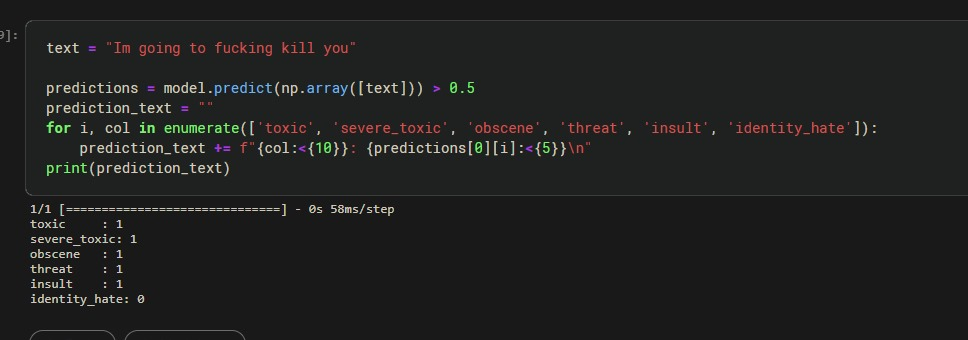